In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns

from catboost import CatBoostClassifier
from catboost import Pool, cv

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import recall_score
from sklearn.decomposition import PCA

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

In [6]:
trans1 = pd.read_csv("../data/data_train/data_train/2_trans_100.csv")
trans2 = pd.read_csv("../data/data_train/data_train/2_trans_2803.csv")
trans3 = pd.read_csv("../data/data_train/data_train/2_trans_1017.csv")
trans4 = pd.read_csv("../data/data_train/data_train/2_trans_1018.csv")

In [7]:
FOLDER_PATH = "../data/data_train/data_train/"

df_all = []
for file in os.listdir(FOLDER_PATH):
    df_trans = pd.read_csv(f"{FOLDER_PATH}/{file}", sep = ",")
    df_trans['id'] = file
    df_all.append(df_trans)
df_all = pd.concat(df_all)
df_all

,H2,CO,C2H4,C2H2,id
0,0.002420,0.015449,0.002487,0.000298,2_trans_100.csv
1,0.002422,0.015470,0.002492,0.000298,2_trans_100.csv
2,0.002425,0.015491,0.002496,0.000299,2_trans_100.csv
3,0.002428,0.015512,0.002502,0.000299,2_trans_100.csv
4,0.002430,0.015534,0.002507,0.000299,2_trans_100.csv
...,...,...,...,...,...
415,0.003548,0.038947,0.009314,0.000266,2_trans_997.csv
416,0.003556,0.039054,0.009335,0.000266,2_trans_997.csv
417,0.003563,0.039161,0.009355,0.000267,2_trans_997.csv
418,0.003570,0.039268,0.009376,0.000268,2_trans_997.csv


In [15]:
def calc_group_mean(df: pd.DataFrame):
    return df.groupby('id').mean(), 'mean'

def calc_group_median(df: pd.DataFrame):
    return df.groupby('id').median(), 'median'

def calc_group_std(df: pd.DataFrame):
    return df.groupby('id').std(), 'std'

def calc_group_cumsum(df: pd.DataFrame):
    return df_all.groupby(['id'])[['H2', 'CO', 'C2H4', 'C2H2']].apply(lambda x: x.cumsum().mean()), 'cumsum'

def calc_group_min(df: pd.DataFrame):
    return df.groupby('id').min(), 'min'

def calc_group_max(df: pd.DataFrame):
    return df.groupby('id').max(), 'max'

def calc_group_cummin(df: pd.DataFrame):
    return df_all.groupby(['id'])[['H2', 'CO', 'C2H4', 'C2H2']].apply(lambda x: x.cummin().mean()), 'cummin'

def calc_group_cummax(df: pd.DataFrame):
    return df_all.groupby(['id'])[['H2', 'CO', 'C2H4', 'C2H2']].apply(lambda x: x.cummax().mean()), 'cummax'

def calc_group_sum(df: pd.DataFrame):
    return df.groupby('id').sum(), 'sum'

def calc_group_sqrt(df: pd.DataFrame):
    return df_all.groupby(['id'])[['H2', 'CO', 'C2H4', 'C2H2']].apply(lambda x: (x **(1/2)).median()), 'sqrt'

def calc_group_square(df: pd.DataFrame):
    return df_all.groupby(['id'])[['H2', 'CO', 'C2H4', 'C2H2']].apply(lambda x: (x ** (2)).median()), 'square'

def calc_group_logplus(df: pd.DataFrame):
    return df_all.groupby(['id'])[['H2', 'CO', 'C2H4', 'C2H2']].apply(lambda x: (x + 1).transform(np.log).mean()), 'logplus'

def calc_group_logmin(df: pd.DataFrame):
    return df_all.groupby(['id'])[['H2', 'CO', 'C2H4', 'C2H2']].apply(lambda x: (x.min() + 1).transform(np.log)), 'logmin'

func_list = [calc_group_mean, calc_group_median, calc_group_std, calc_group_cumsum, calc_group_min, calc_group_max,\
              calc_group_cummin, calc_group_cummax, calc_group_sum, calc_group_sqrt, calc_group_square, calc_group_logplus, calc_group_logmin]

In [ ]:
func_list = [calc_group_mean, calc_group_median, calc_group_std, calc_group_cumsum]
func_list = [calc_group_mean, calc_group_median, calc_group_std, calc_group_cumsum, calc_group_min, calc_group_max,\
              calc_group_cummin, calc_group_cummax, calc_group_sum, calc_group_sqrt, calc_group_square, calc_group_logplus, calc_group_logmin]

In [17]:
df_features = []
for func in func_list:
    df1, name = func(df_all)
    df1.columns = [f'{col}_{name}' for col in df1.columns]
    df_features.append(df1)
df_features = pd.concat(df_features, axis=1)
df_features

,H2_mean,CO_mean,C2H4_mean,C2H2_mean,H2_median,CO_median,C2H4_median,C2H2_median,H2_std,CO_std,...,C2H4_square,C2H2_square,H2_logplus,CO_logplus,C2H4_logplus,C2H2_logplus,H2_logmin,CO_logmin,C2H4_logmin,C2H2_logmin
id,,,,,,,,,,,,,,,,,,,,,
2_trans_100.csv,0.002590,0.016491,0.002876,0.000336,0.002552,0.016290,0.002775,0.000316,0.000148,0.001462,...,0.000008,1.001519e-07,0.002586,0.016355,0.002872,0.000336,0.002417,0.014762,0.002483,0.000298
2_trans_1000.csv,0.002825,0.014728,0.001992,0.000339,0.002680,0.012321,0.002006,0.000338,0.000500,0.005754,...,0.000004,1.140931e-07,0.002821,0.014604,0.001990,0.000339,0.002298,0.009390,0.001318,0.000308
2_trans_1001.csv,0.002764,0.017030,0.003394,0.000195,0.002620,0.015736,0.003190,0.000184,0.000339,0.003381,...,0.000010,3.390007e-08,0.002760,0.016881,0.003388,0.000195,0.002389,0.013065,0.003038,0.000151
2_trans_1002.csv,0.000508,0.016334,0.004104,0.000380,0.000413,0.015559,0.003827,0.000351,0.000187,0.002203,...,0.000015,1.230878e-07,0.000508,0.016199,0.004096,0.000380,0.000328,0.013420,0.003487,0.000334
2_trans_1006.csv,0.002654,0.021278,0.004068,0.000124,0.002657,0.021337,0.003687,0.000115,0.000084,0.001558,...,0.000014,1.317910e-08,0.002651,0.021054,0.004059,0.000124,0.002527,0.018385,0.002930,0.000099
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2_trans_993.csv,0.002549,0.009460,0.007465,0.000242,0.002521,0.005688,0.007268,0.000226,0.000150,0.007288,...,0.000053,5.126265e-08,0.002545,0.009390,0.007437,0.000242,0.002387,0.002609,0.006665,0.000211
2_trans_994.csv,0.000915,0.005770,0.007230,0.000081,0.000747,0.005898,0.007217,0.000073,0.000331,0.000740,...,0.000052,5.361601e-09,0.000915,0.005753,0.007204,0.000081,0.000633,0.004644,0.006727,0.000037
2_trans_995.csv,0.001565,0.002492,0.008529,0.000176,0.001288,0.002459,0.008511,0.000177,0.000728,0.000477,...,0.000072,3.125452e-08,0.001564,0.002489,0.008493,0.000176,0.000803,0.001927,0.007687,0.000160


In [40]:
train_labels = pd.read_csv("../data/train.csv")
train_labels.sort_values("id", inplace = True)
train_labels.set_index("id", inplace = True)

In [7]:
train_labels

,category
id,
2_trans_100.csv,1
2_trans_1000.csv,1
2_trans_1001.csv,1
2_trans_1002.csv,1
2_trans_1006.csv,1
...,...
2_trans_993.csv,1
2_trans_994.csv,3
2_trans_995.csv,3


In [11]:
dfx = train_labels.reset_index().groupby(['category'], as_index=False).count()

In [12]:
dfx

,category,id
0,1,1705
1,2,89
2,3,113
3,4,193


In [19]:
dfx[dfx['category']!=1]['id'].sum()

395

In [22]:
dfx[dfx['category']!=1]['id'].sum() / dfx[dfx['category']==1]['id'][0]

0.2316715542521994

In [21]:
dfx[dfx['category']==1]['id'][0]

1705

In [112]:
x_train, x_test, y_train, y_test = train_test_split(df_features, train_labels, test_size = 0.2, random_state = 1, stratify = train_labels)

In [113]:
cat = CatBoostClassifier(random_state=1, task_type='GPU')
cat.fit(x_train, y_train)

Learning rate set to 0.072152
0:	learn: 1.2223955	total: 19.1ms	remaining: 19.1s
1:	learn: 1.0975672	total: 38.2ms	remaining: 19s
2:	learn: 0.9942045	total: 54.3ms	remaining: 18s
3:	learn: 0.9069664	total: 64.8ms	remaining: 16.1s
4:	learn: 0.8335991	total: 75ms	remaining: 14.9s
5:	learn: 0.7692322	total: 85.3ms	remaining: 14.1s
6:	learn: 0.7139000	total: 95.2ms	remaining: 13.5s
7:	learn: 0.6636684	total: 105ms	remaining: 13s
8:	learn: 0.6193846	total: 114ms	remaining: 12.6s
9:	learn: 0.5791048	total: 124ms	remaining: 12.3s
10:	learn: 0.5431955	total: 133ms	remaining: 12s
11:	learn: 0.5099241	total: 142ms	remaining: 11.7s
12:	learn: 0.4805731	total: 151ms	remaining: 11.5s
13:	learn: 0.4526342	total: 160ms	remaining: 11.2s
14:	learn: 0.4275867	total: 168ms	remaining: 11s
15:	learn: 0.4052161	total: 177ms	remaining: 10.9s
16:	learn: 0.3848308	total: 185ms	remaining: 10.7s
17:	learn: 0.3663217	total: 193ms	remaining: 10.5s
18:	learn: 0.3482181	total: 201ms	remaining: 10.4s
19:	learn: 0.332

In [114]:
y_pred = cat.predict(x_test)

In [115]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.98      0.99      0.98       341
           2       0.88      0.78      0.82        18
           3       0.90      0.83      0.86        23
           4       0.79      0.79      0.79        38

    accuracy                           0.95       420
   macro avg       0.89      0.85      0.86       420
weighted avg       0.95      0.95      0.95       420



<Axes: >

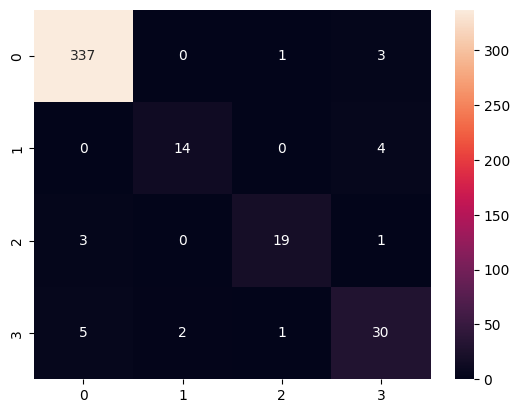

In [116]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="1")

In [122]:
y_pred = pd.DataFrame(y_pred, columns=['label'])

y_test_binary = y_test.replace({'category': {3:2, 4:2}})
y_pred_binary = y_pred.replace({'label': {3:2, 4:2}})


In [124]:
print(classification_report(y_test_binary, y_pred_binary))

              precision    recall  f1-score   support

           1       0.98      0.99      0.98       341
           2       0.95      0.90      0.92        79

    accuracy                           0.97       420
   macro avg       0.96      0.94      0.95       420
weighted avg       0.97      0.97      0.97       420



<Axes: >

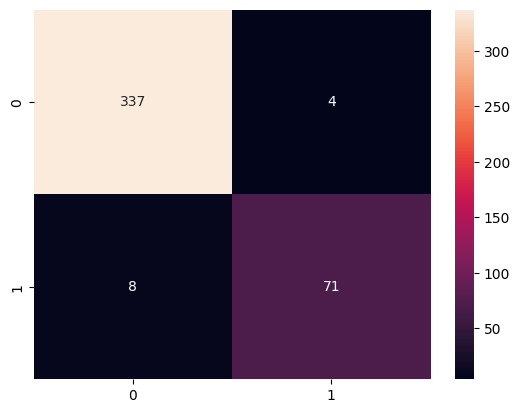

In [123]:
sns.heatmap(confusion_matrix(y_test_binary,y_pred_binary), annot=True, fmt="1")

<Axes: >

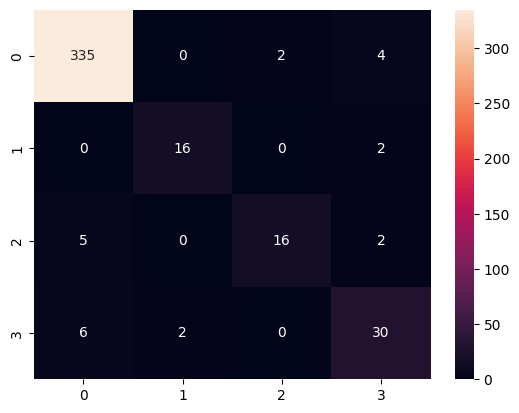

In [23]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="1")

In [24]:
y_pred = pd.DataFrame(y_pred, index=y_test.index, columns=y_test.columns)

In [25]:
y_pred

,category
id,
2_trans_311.csv,1
2_trans_759.csv,1
2_trans_2244.csv,1
2_trans_716.csv,1
2_trans_1643.csv,1
...,...
2_trans_465.csv,1
2_trans_121.csv,4
2_trans_911.csv,1


In [26]:
y_test

,category
id,
2_trans_311.csv,1
2_trans_759.csv,1
2_trans_2244.csv,1
2_trans_716.csv,1
2_trans_1643.csv,1
...,...
2_trans_465.csv,1
2_trans_121.csv,4
2_trans_911.csv,1


In [28]:
y_test['category'].unique()

array([1, 4, 3, 2], dtype=int64)